In [1]:
#import libraries 
import pandas as pd
from patsy import dmatrices
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
import statsmodels.formula.api as smf
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [2]:
csv = '/Users/samuelclark/Documents/UMBC Data Science /Introduction to Data Science/Final Project/Data/merged.csv'
df = pd.read_csv(csv, low_memory=False)
df.columns

Index(['Hour', 'Day', 'Month', 'CrashCount', 'Snow_Dummy', 'Hour_0', 'Hour_1',
       'Hour_2', 'Hour_3', 'Hour_4', 'Hour_5', 'Hour_6', 'Hour_7', 'Hour_8',
       'Hour_9', 'Hour_10', 'Hour_11', 'Hour_12', 'Hour_13', 'Hour_14',
       'Hour_15', 'Hour_16', 'Hour_17', 'Hour_18', 'Hour_19', 'Hour_20',
       'Hour_21', 'Hour_22', 'Hour_23', 'Day_1', 'Day_2', 'Day_3', 'Day_4',
       'Day_5', 'Day_6', 'Day_7', 'Day_8', 'Day_9', 'Day_10', 'Day_11',
       'Day_12', 'Day_13', 'Day_14', 'Day_15', 'Day_16', 'Day_17', 'Day_18',
       'Day_19', 'Day_20', 'Day_21', 'Day_22', 'Day_23', 'Day_24', 'Day_25',
       'Day_26', 'Day_27', 'Day_28', 'Day_29', 'Day_30', 'Day_31', 'Month_1',
       'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7',
       'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12',
       'Precipitation', 'No_Precipitation'],
      dtype='object')

In [3]:
#test, train, split
mask = np.random.rand(len(df)) < 0.8
df_train = df[mask]
df_test = df[~mask]
print('Training data set length='+str(len(df_train)))
print('Testing data set length='+str(len(df_test)))

Training data set length=7015
Testing data set length=1741


In [4]:
#regerssion formula
expr = """CrashCount ~ Hour_0 + Hour_1 + Hour_2 + Hour_3 + Hour_4 + Hour_5 + Hour_6 + Hour_7 + Hour_8 + Hour_9 + 
                        Hour_10 + Hour_11 + Hour_12 + Hour_13 + Hour_14 + Hour_15 + Hour_16 + Hour_17 + Hour_18 + 
                        Hour_19 + Hour_20 + Hour_21 + Hour_22 + Hour_23 + Month_1 + Month_2 + Month_3 +
                        Month_4 + Month_5 + Month_6 + Month_7 + Month_8 + Month_9 + Month_10 + 
                        Month_11 + Month_12 + Day + Precipitation + No_Precipitation"""  

expr2 = """CrashCount ~ Hour_0 + Hour_1 + Hour_2 + Hour_3 + Hour_4 + Hour_5 + Hour_6 + Hour_7 + Hour_8 + Hour_9 + 
                        Hour_10 + Hour_11 + Hour_12 + Hour_13 + Hour_14 + Hour_15 + Hour_16 + Hour_17 + Hour_18 + 
                        Hour_19 + Hour_20 + Hour_21 + Hour_22 + Hour_23 + Day_1 + Day_2 + Day_3 + Day_4 + Day_5 + 
                        Day_6 + Day_7 + Day_8 + Day_9 + Day_10 + Day_11 + Day_12 + Day_13 + Day_14 + Day_15 + Day_16 + 
                        Day_17 + Day_18 + Day_19 + Day_20 + Day_21 + Day_22 + Day_23 + Day_24 + Day_25 + Day_26 + 
                        Day_27 + Day_28 + Day_29 + Day_30 + Day_31 + Month_1 + Month_2 + Month_3 +
                        Month_4 + Month_5 + Month_6 + Month_7 + Month_8 + Month_9 + Month_10 + 
                        Month_11 + Month_12 + Precipitation """             

In [5]:
#set up matricies
y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')

In [6]:
#poission
poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
print(poisson_training_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             CrashCount   No. Observations:                 7015
Model:                            GLM   Df Residuals:                     6978
Model Family:                 Poisson   Df Model:                           36
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -19869.
Date:                Thu, 29 Apr 2021   Deviance:                       10200.
Time:                        17:30:12   Pearson chi2:                 1.01e+04
No. Iterations:                   100                                         
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            1.4964      0.005  

In [7]:
#Compute estimated over dispersion.
#There is over dispersion so we can not use the poission regression
ratio = poisson_training_results.pearson_chi2/poisson_training_results.df_resid
print(ratio)

1.4520849056029321


In [8]:
#Getting test results from the test data
poisson_predictions = poisson_training_results.get_prediction(X_test)
predictions_summary_frame = poisson_predictions.summary_frame()
print(predictions_summary_frame)

           mean   mean_se  mean_ci_lower  mean_ci_upper
4     18.879039  0.347563      18.209973      19.572689
10    18.084495  0.343148      17.424291      18.769715
18    17.781516  0.330885      17.144678      18.442010
22    18.054274  0.340547      17.399001      18.734225
25    15.010993  0.291893      14.449658      15.594135
...         ...       ...            ...            ...
8726  14.536994  0.282179      13.994321      15.100711
8734  17.338782  0.329792      16.704303      17.997361
8736  16.962158  0.324874      16.337220      17.611002
8739  15.384267  0.311473      14.785745      16.007017
8748  15.633370  0.305088      15.046699      16.242914

[1741 rows x 4 columns]


<Figure size 432x288 with 0 Axes>

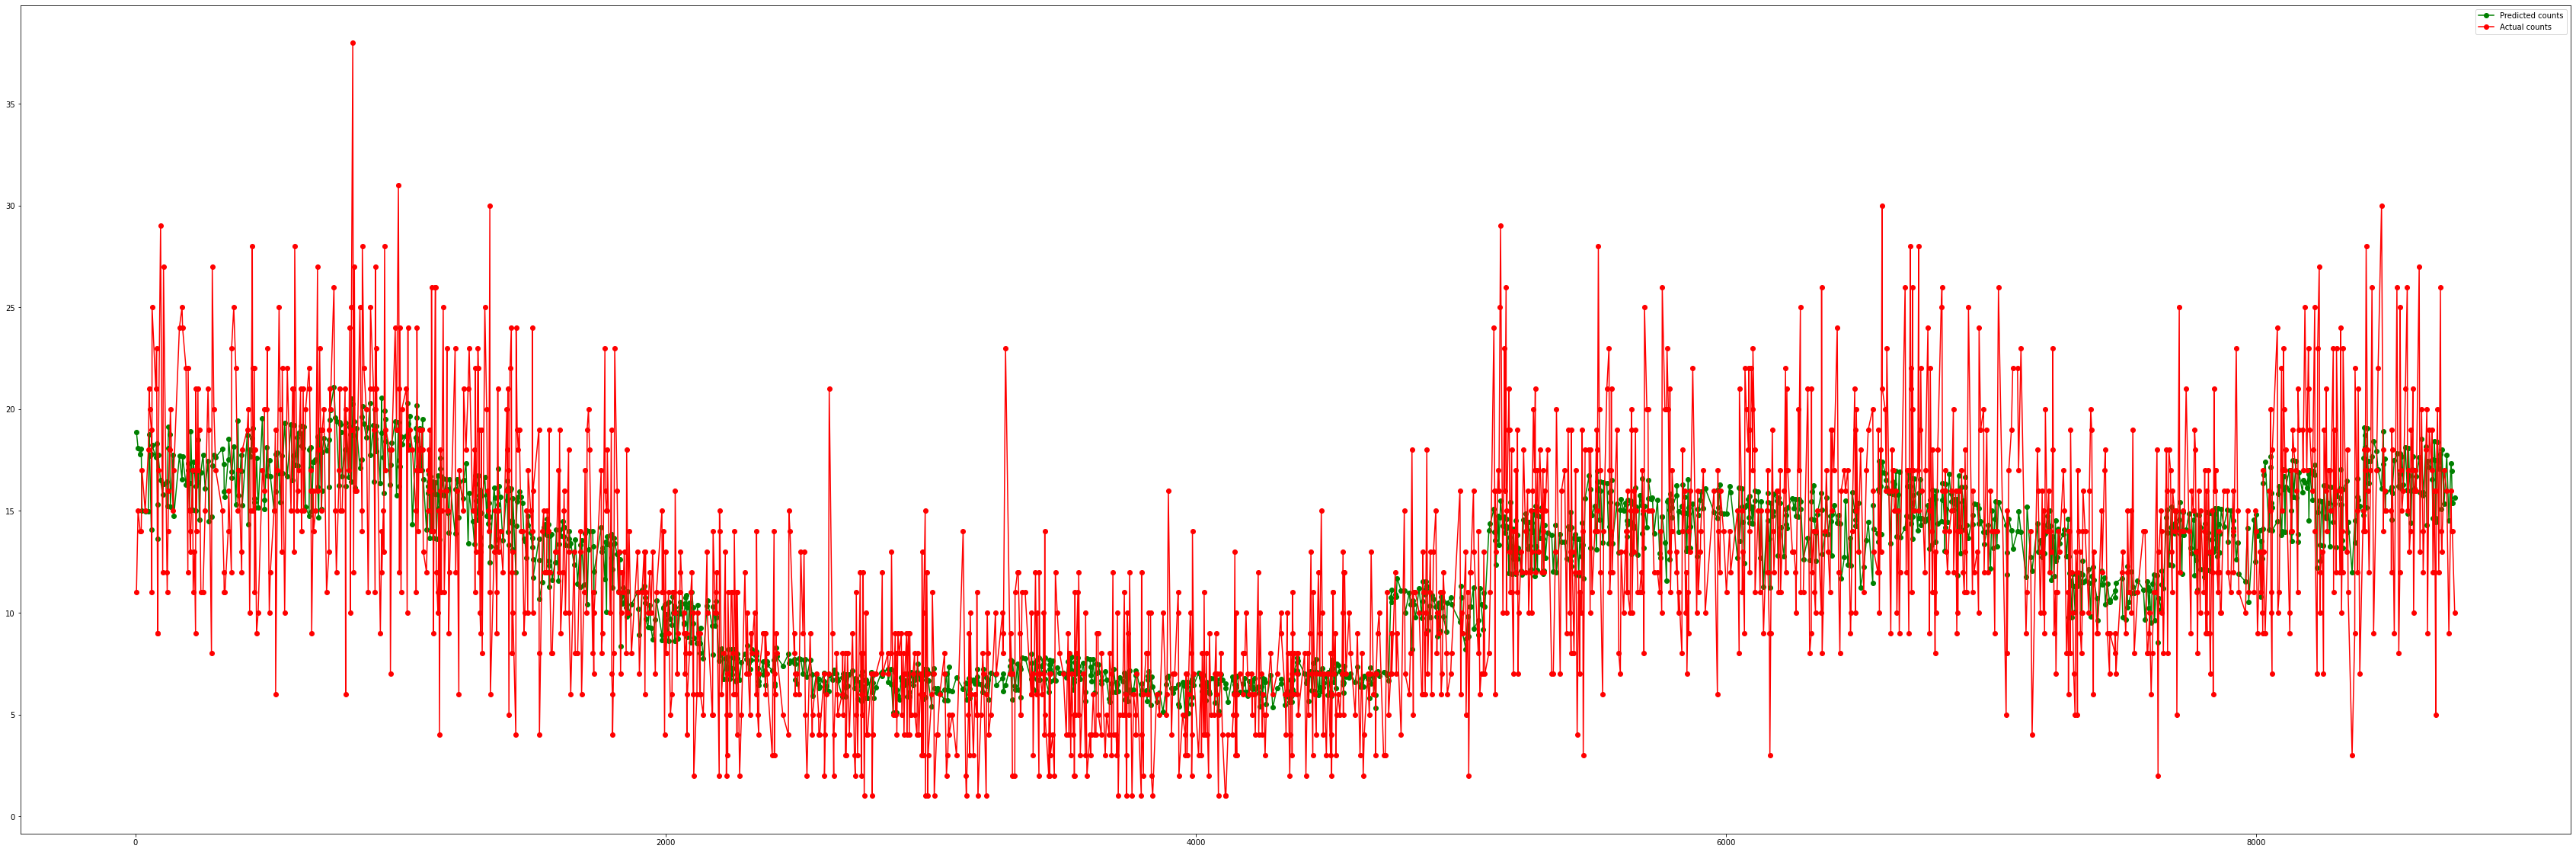

<Figure size 432x288 with 0 Axes>

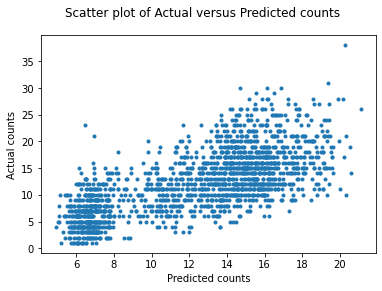

In [9]:
#Plotting actual and predicted results against the index of the data
predicted_counts=predictions_summary_frame['mean']
actual_counts = y_test['CrashCount']
fig = plt.figure()
plt.figure(figsize=(60, 20))
fig.suptitle('Predicted versus actual bicyclist counts on the Brooklyn bridge')
predicted, = plt.plot(X_test.index, predicted_counts, 'go-', label='Predicted counts')
actual, = plt.plot(X_test.index, actual_counts, 'ro-', label='Actual counts')
plt.legend(handles=[predicted, actual])
plt.show()

#scatterplot of actual vs predicted

plt.clf()
fig = plt.figure()
fig.suptitle('Scatter plot of Actual versus Predicted counts')
plt.scatter(x=predicted_counts, y=actual_counts, marker='.')
plt.xlabel('Predicted counts')
plt.ylabel('Actual counts')
plt.show()

In [10]:
#negative binomial regression
NB_training_results = sm.GLM(y_train, X_train, family = sm.families.NegativeBinomial(alpha =1)).fit()
print(NB_training_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             CrashCount   No. Observations:                 7015
Model:                            GLM   Df Residuals:                     6978
Model Family:        NegativeBinomial   Df Model:                           36
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -24383.
Date:                Thu, 29 Apr 2021   Deviance:                       945.55
Time:                        17:30:13   Pearson chi2:                     873.
No. Iterations:                   100                                         
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            1.4897      0.017  

In [11]:
#Compute estimated over dispersion.
#There is over dispersion so we can not use the poission regression
ratio = NB_training_results.pearson_chi2/NB_training_results.df_resid
print(ratio)

0.1250547659691105


In [12]:
#prediction on the X training set. Mean is predicted values of the train set
NB_prediction = NB_training_results.get_prediction(X_test)
NB_predicted_summary_frame = NB_prediction.summary_frame()
print(NB_predicted_summary_frame)

           mean   mean_se  mean_ci_lower  mean_ci_upper
4     18.999669  1.419210      16.412101      21.995198
10    18.129868  1.373723      15.627807      21.032517
18    18.096312  1.347774      15.638477      20.940435
22    18.102070  1.364807      15.615355      20.984790
25    15.059688  1.131242      12.997987      17.448411
...         ...       ...            ...            ...
8726  14.614972  1.101896      12.607287      16.942376
8734  17.428467  1.328338      15.010098      20.236475
8736  17.038563  1.299069      14.673541      19.784770
8739  15.043997  1.192046      12.880014      17.571553
8748  15.726340  1.202873      13.536959      18.269816

[1741 rows x 4 columns]


<Figure size 432x288 with 0 Axes>

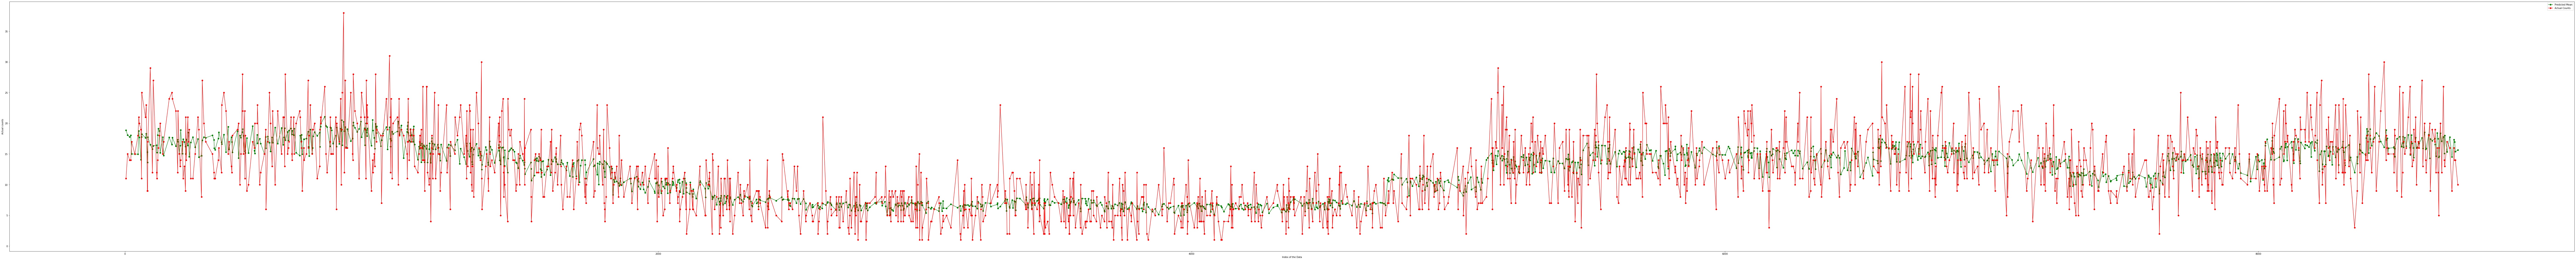

<Figure size 432x288 with 0 Axes>

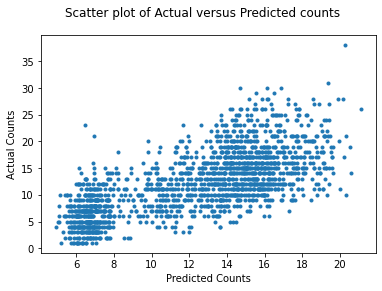

In [13]:
#plot of actual and predicted values against an index
NB_predicted_summary_frame=predictions_summary_frame['mean']
actual_counts = y_test['CrashCount']
fig = plt.figure()
plt.figure(figsize=(200, 20))
fig.suptitle('Predicted versus actual car crash counts')
plt.xlabel('Index of the Data')
plt.ylabel('Actual counts')
predicted, = plt.plot(X_test.index, predicted_counts, 'go-', label='Predicted Mean')
actual, = plt.plot(X_test.index, actual_counts, 'ro-', label='Actual Counts')
plt.legend(handles=[predicted, actual])
plt.show()


#scatter of actual v prediced
plt.clf()
fig = plt.figure()
fig.suptitle('Scatter plot of Actual versus Predicted counts')
plt.scatter(x=NB_predicted_summary_frame, y=actual_counts, marker='.')
plt.xlabel('Predicted Counts')
plt.ylabel('Actual Counts')
plt.show()

In [14]:
#root mean squared error 
y_actual = y_test
y_predicted = NB_predicted_summary_frame['mean']

rmse = mean_squared_error(y_actual, y_predicted, squared=False)
print(rmse)
print(y_predicted.max())
print(y_predicted.min())

KeyError: 'mean'

In [ ]:
#comparing poission and negative binomial models by the liklihood ratio test


In [ ]:
#Goodness fit by Pearsons and deviance


In [ ]:
#cross valdiation
